# Project: Capstone Project 1- Forecasting short term solar energy: Data Wrangling

# Introduction
The purpose of the current project is to do data wrangling to prepare the data for the next step of the original project, - to forecast day ahead solar energy production at Oklahoma Mesonet stations using linear regression machine learning algorithm. The complete dataset required for this project is obtained from the Kaggle site (https://www.kaggle.com/c/ams-2014-solar-energy-prediction-contest). Although data wrangling is implemented on all input variables only the temperature data is presented in this part of work for brevity.

# Importing necessary modules

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
from scipy import interpolate
import matplotlib.pyplot as plt
from datetime import datetime

# Data acquire
The dataset was downloaded from the Kaggle site in netcdf files.

In [3]:
# load dataset and select the necessary variable to process
data = nc.Dataset("C:\\Users\\manas\\Desktop\\Springboard\\Capstone ideas\\Solar energy\\gefs_train\\train\\tmp_2m_latlon_subset_19940101_20071231.nc")
for v in data.variables.keys():
    print(v)

# data variables and their structure
for d in data.dimensions.values():
    print(d)

lat = data.variables['lat']
print(lat.shape)
lon = data.variables['lon']
print(lon.shape)
t = data.variables['Temperature_height_above_ground']
print(t.shape)
l = lat[:]
n = lon[:]

time
intTime
lat
lon
ens
fhour
intValidTime
Temperature_height_above_ground
<class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 5113

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 9

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 16

<class 'netCDF4._netCDF4.Dimension'>: name = 'ens', size = 11

<class 'netCDF4._netCDF4.Dimension'>: name = 'fhour', size = 5

(9,)
(16,)
(5113, 11, 5, 9, 16)


# Reshaping data
We need only 5 x 10 = 50 grid points (from lat: 33 - 37 N (i.e., 5 grid points), lon: 257 - 266 W (i.e., 10 grid points)) instead of 9 x 16 grid points to cover all Mesonet stations. Downscaling to a smaller grid will reduce the space for data storage greatly. The original dataset has the dimension (5113, 11, 5, 9, 16). The last two dimensions corresond to lattitude and longitude. Extracting the data for each grid points reduce the dimension to (5113, 11, 5). These dimensions correspond to time, model ensemble outcome and timesteps each day: 11 model ensemble predicting weather variables 5 times each day resulting to a total of 5113 days of dataset. Then it is reshaped into a 2 dimensional dataset, i.e., (5113, 55) from 3 dimensional dataset, i.e., (5113, 11, 5) and written in files for each grid point.


In [4]:
# reshaping data file for a smaller grid (latitude range 33 - 38, longitude range 257 - 267) which cover all stations
for lat in range(33, 38): 
    l_in = np.where(l == lat)[0][0]
    for lon in range(257, 267):
        n_in = np.where(n == lon)[0][0]
        filename = 't_'+str(lat)+ '_'+str(lon)
        fileval = t[:,:,:,l_in,n_in]
        
        # reshaping fileval from (5113, 11, 5) to (5113, 55)
        fileval = fileval.reshape(fileval.shape[0], fileval.shape[1]*fileval.shape[2])
        
        # saving the  data for each grid point
        filepath = "C:/Users/manas/Desktop/Springboard/Capstone ideas/Solar energy/Data/Temp/" + filename +str('.csv')
        np.savetxt(filepath, fileval, delimiter=',', fmt = "%0.06f")


# Estimating variable for individual station
The location of the station (latitude, longitude) does not necessarily coincide with the gridpoints which are 1 degree apart, both latitudinally and longitudinally. So the input data files for the surrounding 4 grid points of a station are taken into account in order to estimate the input variable (e.g., temperature) at that mesonet station. Here the estimation is done for station 'ACME', the latitude and longitude for which are obtained from 'station_info.csv' file.

In [5]:
# defining a function to return latitude-longitude info for a chosen station
def station_n_l_e(station_name):
    station_loc = pd.read_csv("C:\\Users\\manas\\Desktop\\Springboard\\Capstone ideas\\Solar energy\\station_info.csv", index_col='stid')
    stn_n_l_e = station_loc.loc[station_name]
    stn_n = stn_n_l_e[0]
    stn_l = stn_n_l_e[1] + 360
    return [stn_n, stn_l]

# Calling function for a chosen station: ACME
list1 = station_n_l_e('ACME')

Xnew=list1[1]
Ynew=list1[0]

# lattitude longitude for the 4 surrounding grids
str_list = [str(math.floor(Ynew)) +'_'+ str(math.floor(Xnew)), 
            str(math.floor(Ynew)) +'_'+ str(math.ceil(Xnew)), 
            str(math.ceil(Ynew)) +'_'+ str(math.floor(Xnew)), 
            str(math.ceil(Ynew)) +'_'+ str(math.ceil(Xnew))]
print('lattitude and longitude of the station:', list1)
print('lattitude and longitude of surrounding grids are (in format lat_lon):', str_list)

# setting filepath for the variable at the surrounding grids
filepath = "C:\\Users\\manas\\Desktop\\Springboard\\Capstone ideas\\Solar energy\\Data\\Temp\\t_"
filename1 = filepath + str_list[0] + '.csv'
filename2 = filepath + str_list[1] + '.csv'
filename3 = filepath + str_list[2] + '.csv'
filename4 = filepath + str_list[3] + '.csv'
filenames = [filename1, filename2, filename3, filename4]

lattitude and longitude of the station: [34.80833, 261.97675]
lattitude and longitude of surrounding grids are (in format lat_lon): ['34_261', '34_262', '35_261', '35_262']


## Data exploration
The data from 4 surrounding grid points need to be interpolated based on their distance from the station to estimate the variable (e.g., temperature) at that station. Before that the data is analyzed to deal with 1. missing / null values, 2. reshaping, and 3. frequency distribution. Then at each gridpoint the data from 11 model ensemble was averaged for each time step. Therefore the mean model outcome was averaged over all timesteps to obtain a daily average. The correlation among the averaged daily values from each grid points are analyzed as well.  
. 


Summary statistics of the variable at 4 surrounding grid points:
              34_261         34_262         35_261         35_262
25%       284.460877     284.248413     282.705627     282.706039
50%       293.255188     292.794434     291.554657     291.388428
75%       301.054902     300.115097     299.660324     298.935105
count  281215.000000  281215.000000  281215.000000  281215.000000
max       319.109375     317.148987     318.041870     315.309387
mean      292.625242     292.044616     291.083037     290.666603
min       250.836716     253.031235     250.076721     248.564392
std        10.714237      10.319384      10.948172      10.550301

Correlation of the surrounding grid variables:
          34_261    34_262    35_261    35_262
34_261  1.000000  0.996846  0.995620  0.994998
34_262  0.996846  1.000000  0.991207  0.995284
35_261  0.995620  0.991207  1.000000  0.997290
35_262  0.994998  0.995284  0.997290  1.000000


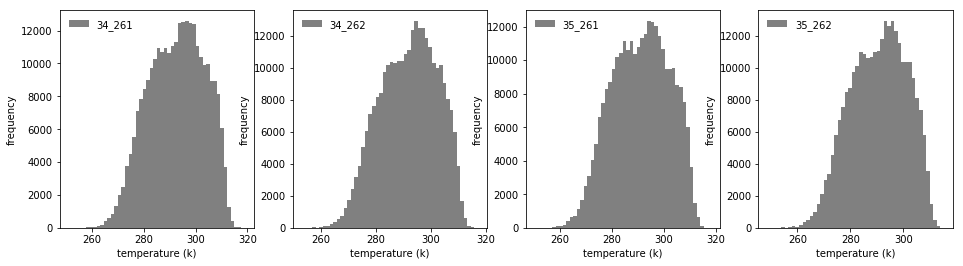

In [6]:
# creating subplots for each grid point
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))
p_con = pd.DataFrame()
p_des_con = pd.DataFrame()
avg_grid = pd.DataFrame()

# for each grid point surrounding the station
for k in range(4):
    
    p_grid = pd.read_csv(filenames[k], header=None)
           
    # Null data check
    assert pd.notnull(p_grid).all().all()
       
    # reshaping: from 2d:5113 x 55 to 1d: 281215
    p = p_grid.melt()
    
    # statistical summary
    p_des = p.describe().value
    p_des_con = pd.concat([p_des_con, p_des], axis=1 )
    p_con = pd.concat([p_con, p['value']], axis=1 )
    
    # frequency distribution of the variable    
    ax = axes[k]
    ax.hist(p['value'], bins=50, color='gray', label=str_list[k])
    ax.set_xlabel('temperature (k)')
    ax.set_ylabel('frequency')
    leg=ax.legend(loc='upper left')
    leg.draw_frame(False)
     
    # Averaging data over model estimation and timesteps. There are 5 timesteps in a day (lets say: t0, t1, t2, t3, t4)
    #We will combine 11 model prediction at each timestep first and then average over time.
       
    # looping over timesteps
    model_mean_t=pd.DataFrame()
    for j in range(0,5):
        
        model_en = p_grid[j]
        for i in range(0,50,5):
            model_en = pd.concat([model_en, p_grid[i+j+5]], axis=1)
        
        # averaging model ensemble    
        model_mean = np.mean(model_en, axis=1)
    
        model_mean_t = pd.concat([model_mean_t, model_mean], axis=1)
    
    # averaging over timesteps
    model_mean_t_mean = np.mean(model_mean_t, axis=1)
    
    # concating avg from all 4 grids
    avg_grid = pd.concat([avg_grid, model_mean_t_mean], axis=1)
    
    # saving the averaged value from 4 surrounding grids
    filepath1 = "C:\\Users\\manas\\Desktop\\Springboard\\Capstone ideas\\Solar energy\\Data\\Temp\\model_t_mean_"
    filename= filepath1 + str_list[k] + '.csv'
    np.savetxt(filename, model_mean_t_mean, delimiter=',', fmt = "%0.06f")
    
p_des_con.columns = str_list
p_con.columns = str_list

print('')
print('Summary statistics of the variable at 4 surrounding grid points:')
print(p_des_con)
avg_grid.columns = str_list

# evaluate correlation among the gridpoint variables
print('')
print('Correlation of the surrounding grid variables:')
print(avg_grid.corr())

### Discussion
There is no NULL data for station 'ACME'. That is not surprising given that those are model predictions and not measured data. The summary statistics and the frequency distribution from the surrounding grids are quite similar.The correlation table shows a strong linear relation among the data from all grids. That is plausible as the temperature change is gradual with latitude due to change in angle of incoming sunlight. So the linear interpolation seems to be quite apt for estimating the value at the station. 

## Interpolating variable at station
The variable is linearly interpolated based on the distance of the 4 surrounding grid points and then written in file.

In [7]:
# Interpolating the variable values from 4 surrounding grid points to the station

x,y = np.meshgrid([math.floor(Xnew), math.ceil(Xnew)],[math.floor(Ynew), math.ceil(Ynew)])

# Setting filepath
# filename: str_list: math.floor(Xnew), math.ceil(Xnew), math.floor(Ynew), math.ceil(Ynew)
str_list = [str(math.floor(Ynew)) +'_'+ str(math.floor(Xnew)), 
            str(math.floor(Ynew)) +'_'+ str(math.ceil(Xnew)), 
            str(math.ceil(Ynew)) +'_'+ str(math.floor(Xnew)), 
            str(math.ceil(Ynew)) +'_'+ str(math.ceil(Xnew))]

filepath = "C:\\Users\\manas\\Desktop\\Springboard\\Capstone ideas\\Solar energy\\Data\\Temp\\model_t_mean_"
filename1 = filepath + str_list[0] + '.csv'
filename2 = filepath + str_list[1] + '.csv'
filename3 = filepath + str_list[2] + '.csv'
filename4 = filepath + str_list[3] + '.csv'
filenames = [filename1, filename2, filename3, filename4]

# loading data for surrounding grids
var1 = pd.read_csv(filename1, header=None)
var1 = var1.rename(columns={var1.columns[0] : 'x1y1'})
var2 = pd.read_csv(filename2, header=None)
var2 = var2.rename(columns={var2.columns[0] : 'x2y1'})
var3 = pd.read_csv(filename3, header=None)
var3 = var3.rename(columns={var3.columns[0] : 'x1y2'})
var4 = pd.read_csv(filename4, header=None)
var4 = var4.rename(columns={var4.columns[0] : 'x2y2'})
var = pd.concat([var1, var2, var3, var4], axis=1)

# interpolating to the station
# z structure([(34,261), (34, 262)], [(35, 261), (35, 262)])
var_station = []
for row in var.values:
    z = [row[0], row[1]], [row[2], row[3]]
    f = interpolate.interp2d(x,y,z,kind='linear')
    interp_val=f(Xnew,Ynew)
    var_station = np.append(var_station, interp_val)

# saving interpolated station data
filepath_var = "C:\\Users\\manas\\Desktop\\Springboard\\Capstone ideas\\Solar energy\\Data\\Temp\\t_station.csv"
np.savetxt(filepath_var, var_station, delimiter=',', fmt = "%0.06f")

### Time series of variable

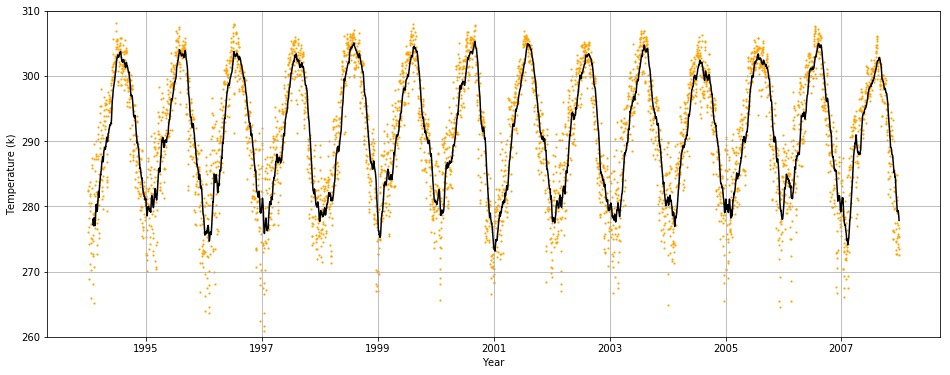

In [10]:
# plotting the variable and its moving average

# Convert Dates to datetime
dates = np.arange(np.datetime64('1994-01-01'), np.datetime64('2008-01-01'))

# Convert numpy to dataframe
x = pd.DataFrame(dates)
y = pd.DataFrame(var_station)
df = pd.concat([x, y], axis=1)
df.columns = ['date', 'temp']

# esttimating the rolling average
df['avg'] = df['temp'].rolling(window=30).mean()

# plotting the time series of temperature and its rolling average
plt.scatter(dates, var_station, s=5, marker='.', color='orange')
plt.ylim(260,310)
plt.xlabel('Year')
plt.ylabel('Temperature (k)')

plt.plot(df['date'], df['avg'], color='black')
plt.rcParams["figure.figsize"] = [16,6]
plt.grid(True)
plt.show()

### Discusison
The temperature time series at 'ACME' demonstrates clear seasonality each year with higher temperature in summer and lower temperature in winter. Further exploratory analysis is done in different notebook.